In [70]:
import xgboost as xgb
from xgboost import XGBClassifier, plot_tree
import pandas as pd

In [71]:
df = pd.read_parquet("./data/DSU-Dataset.parquet")

In [72]:
# # Remove all data points with NaN in label
# nan_df = df[df['High Cost Claim'].isna()]

# df = df.dropna(subset=['High Cost Claim'])

# nan_df.to_parquet('data/test_set.parquet')
# df.to_parquet('data/train_set.parquet')


## Basic data check

In [73]:
df.columns

Index(['Claim ID', 'Service Date', 'Recieved Date', 'Paid Date', 'Patient ID',
       'Member Age', 'Gender', 'Marital Status', 'Ethnicity', 'LOB',
       'Network Status', 'Claim Category', 'Claim Subcategory', 'Claim Line',
       'Place of Service', 'Provider Type', 'Provider Specialty',
       'ICD10 Code 1', 'ICD10 Code 2', 'ICD10 Code 3', 'ICD10 Code 4',
       'ICD10 Code 5', 'ICD10 Code 6', 'ICD10 Code 7', 'ICD10 Code 8',
       'ICD10 Code 9', 'ICD10 Code 10', 'Service Type', 'Service Code',
       'Modifiers', 'High Cost Claim'],
      dtype='object')

In [74]:
df.dtypes

Claim ID               object
Service Date           object
Recieved Date          object
Paid Date              object
Patient ID             object
Member Age             object
Gender                 object
Marital Status         object
Ethnicity              object
LOB                    object
Network Status         object
Claim Category         object
Claim Subcategory      object
Claim Line             object
Place of Service       object
Provider Type          object
Provider Specialty     object
ICD10 Code 1          float64
ICD10 Code 2          float64
ICD10 Code 3          float64
ICD10 Code 4          float64
ICD10 Code 5          float64
ICD10 Code 6          float64
ICD10 Code 7          float64
ICD10 Code 8          float64
ICD10 Code 9          float64
ICD10 Code 10         float64
Service Type           object
Service Code           object
Modifiers              object
High Cost Claim       float64
dtype: object

In [75]:
df.head()

,Claim ID,Service Date,Recieved Date,Paid Date,Patient ID,Member Age,Gender,Marital Status,Ethnicity,LOB,...,ICD10 Code 5,ICD10 Code 6,ICD10 Code 7,ICD10 Code 8,ICD10 Code 9,ICD10 Code 10,Service Type,Service Code,Modifiers,High Cost Claim
0,8110afaab1020212f58193e233369c1ac352baf280637c...,2022-01-15,2022-01-17,2022-01-25,99f69b741b2784601452afbe7f9083b5ab984b1b7acc64...,10-19 Yrs Old,F,Single,Caucasian/White,SGH,...,NaN,NaN,NaN,NaN,NaN,NaN,PROC,U0005,None,NaN
1,8110afaab1020212f58193e233369c1ac352baf280637c...,2022-01-15,2022-01-17,2022-01-25,99f69b741b2784601452afbe7f9083b5ab984b1b7acc64...,10-19 Yrs Old,F,Single,Caucasian/White,SGH,...,NaN,NaN,NaN,NaN,NaN,NaN,PROC,U0003,None,NaN
2,190430199dfa0b3ed46212060301b3d743d64f958fa505...,2022-01-05,2022-01-06,2022-01-10,79c25d5d6a0cec975ddcd349f1c431eec1ff698295e752...,10-19 Yrs Old,M,Single,Caucasian/White,NPS,...,NaN,NaN,NaN,NaN,NaN,NaN,PROC,73630,"TC,LT",0.0
3,cac4ce65912da45e6350bf9528623f921762a436056721...,2021-12-28,2021-12-30,2022-01-03,2fe692eb90cbcb4a2afa053ac41691f4a93f7acbd8c357...,50-59 Yrs Old,F,Divorced,Caucasian/White,NPS,...,NaN,NaN,NaN,NaN,NaN,NaN,PROC,87426,None,0.0
4,e01f80a521e095d6fe969a0342a74c23d886c0e324d314...,2022-01-05,2022-01-06,2022-01-13,64c05a5a40591a5f00d0868167a22d37515c65581dd511...,1-9 Yrs Old,F,Single,Caucasian/White,SGH,...,NaN,NaN,NaN,NaN,NaN,NaN,PROC,90670,None,0.0


## Change types of columns to datetime

In [76]:
df[['Service Date', 'Recieved Date', 'Paid Date']] = df[['Service Date', 'Recieved Date', 'Paid Date']].apply(pd.to_datetime)

### Compute time difference between recieved date/ service date and paid date/ recieve date

In [77]:
df['recieve delay'] = (df['Recieved Date'] - df['Service Date']).dt.days
df['payment delay'] = (df['Paid Date'] - df['Recieved Date']).dt.days

In [78]:
df['payment delay'].max()

980

In [87]:
df.shape

(203250, 35)

In [79]:
df['Month'] = pd.to_datetime(df['Service Date']).dt.month
df['Day of Week'] = pd.to_datetime(df['Service Date']).dt.dayofweek

In [80]:
na_data = df[df['High Cost Claim'].isna()]

In [81]:
df = df.dropna(subset=['High Cost Claim'])

In [82]:
labels = df['High Cost Claim']
cols_to_drop = ['Claim ID', 'Patient ID', 'Service Date', 'Recieved Date', 'Paid Date', 'Modifiers', 'High Cost Claim']
df_short = df.drop(cols_to_drop, axis=1)

In [83]:
df_short.shape

(203250, 28)

In [84]:
labels.isna().sum() # No nulls in df

0

In [85]:
df_short = pd.get_dummies(df_short, columns=df_short.select_dtypes('object').columns)

In [86]:
df_short.shape

(203250, 5111)

In [37]:
df_short.rename({'Member Age_< 1 Yrs Old': 'Member Age_lessthan 1 Yrs Old'}, axis=1, inplace=True) #a feature can't have < as a character

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_short, labels)

In [42]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train)

In [43]:
params = {
    "eval_metric": "aucpr",
    "eta": 0.295,  # learning rate
    "max_depth": 3,
    "max_leaves": 4,
    "lambda": 0.591,  # L2 regularization
    "alpha": 0.146,  # L1 regularization
    "gamma": 0.152,  # Minimum loss reduction required to make a further partition
    "subsample": 0.515,  # Fraction of samples used to fit trees
    "colsample_bytree": 0.656,  # Fraction of features used to fit trees
} 

In [45]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val) 

In [46]:
model = XGBClassifier(params=params, verbosity=2, eval_metric='aucpr')

In [47]:
model.fit(X_train, y_train, eval_set = [(X_val, y_val)]) 

/Users/samyamaryal/Desktop/Data Competition/DSU-Data-Competition-Spring2025/.venv/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:42:41] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "params" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	validation_0-aucpr:0.81408
[1]	validation_0-aucpr:0.86724
[2]	validation_0-aucpr:0.88814
[3]	validation_0-aucpr:0.92040
[4]	validation_0-aucpr:0.93306
[5]	validation_0-aucpr:0.93856
[6]	validation_0-aucpr:0.94629
[7]	validation_0-aucpr:0.95090
[8]	validation_0-aucpr:0.95503
[9]	validation_0-aucpr:0.96122
[10]	validation_0-aucpr:0.96310
[11]	validation_0-aucpr:0.96503
[12]	validation_0-aucpr:0.96898
[13]	validation_0-aucpr:0.97054
[14]	validation_0-aucpr:0.97216
[15]	validation_0-aucpr:0.97331
[16]	validation_0-aucpr:0.97704
[17]	validation_0-aucpr:0.97759
[18]	validation_0-aucpr:0.97817
[19]	validation_0-aucpr:0.97921
[20]	validation_0-aucpr:0.97947
[21]	validation_0-aucpr:0.98282
[22]	validation_0-aucpr:0.98384
[23]	validation_0-aucpr:0.98669
[24]	validation_0-aucpr:0.98905
[25]	validation_0-aucpr:0.99027
[26]	validation_0-aucpr:0.99107
[27]	validation_0-aucpr:0.99122
[28]	validation_0-aucpr:0.99217
[29]	validation_0-aucpr:0.99235
[30]	validation_0-aucpr:0.99328
[31]	validation_0-

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='aucpr', feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_thre...one,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None,
              params={'alpha': 0.146, 'colsample_bytree': 0.656, 'eta': 0.295,
                      'eval_metric': 'aucpr', 'gamma': 0.152, 'lambda': 0.591,
                      'max_depth': 3, 'max_leaves': 4, 'subsample': 0.515}, ...)

In [48]:
model.score(X_test, y_test)

0.9996260799401728

In [49]:
imp = pd.DataFrame(data={"Features ": model.feature_names_in_, "Importances ": model.feature_importances_}) 

In [50]:
y_pred_probs = model.predict_proba(X_test)
y_preds = model.predict(X_test) 

In [51]:
import sklearn 

sklearn.metrics.f1_score(y_test, y_preds) 

0.9974244272739596

In [52]:
y_test.value_counts()

High Cost Claim
0.0    47122
1.0     3691
Name: count, dtype: int64

In [53]:
pd.Series(y_preds).value_counts()

0    47127
1     3686
Name: count, dtype: int64

In [54]:
sklearn.metrics.confusion_matrix(y_test, y_preds) 

array([[47115,     7],
       [   12,  3679]])

<Axes: >

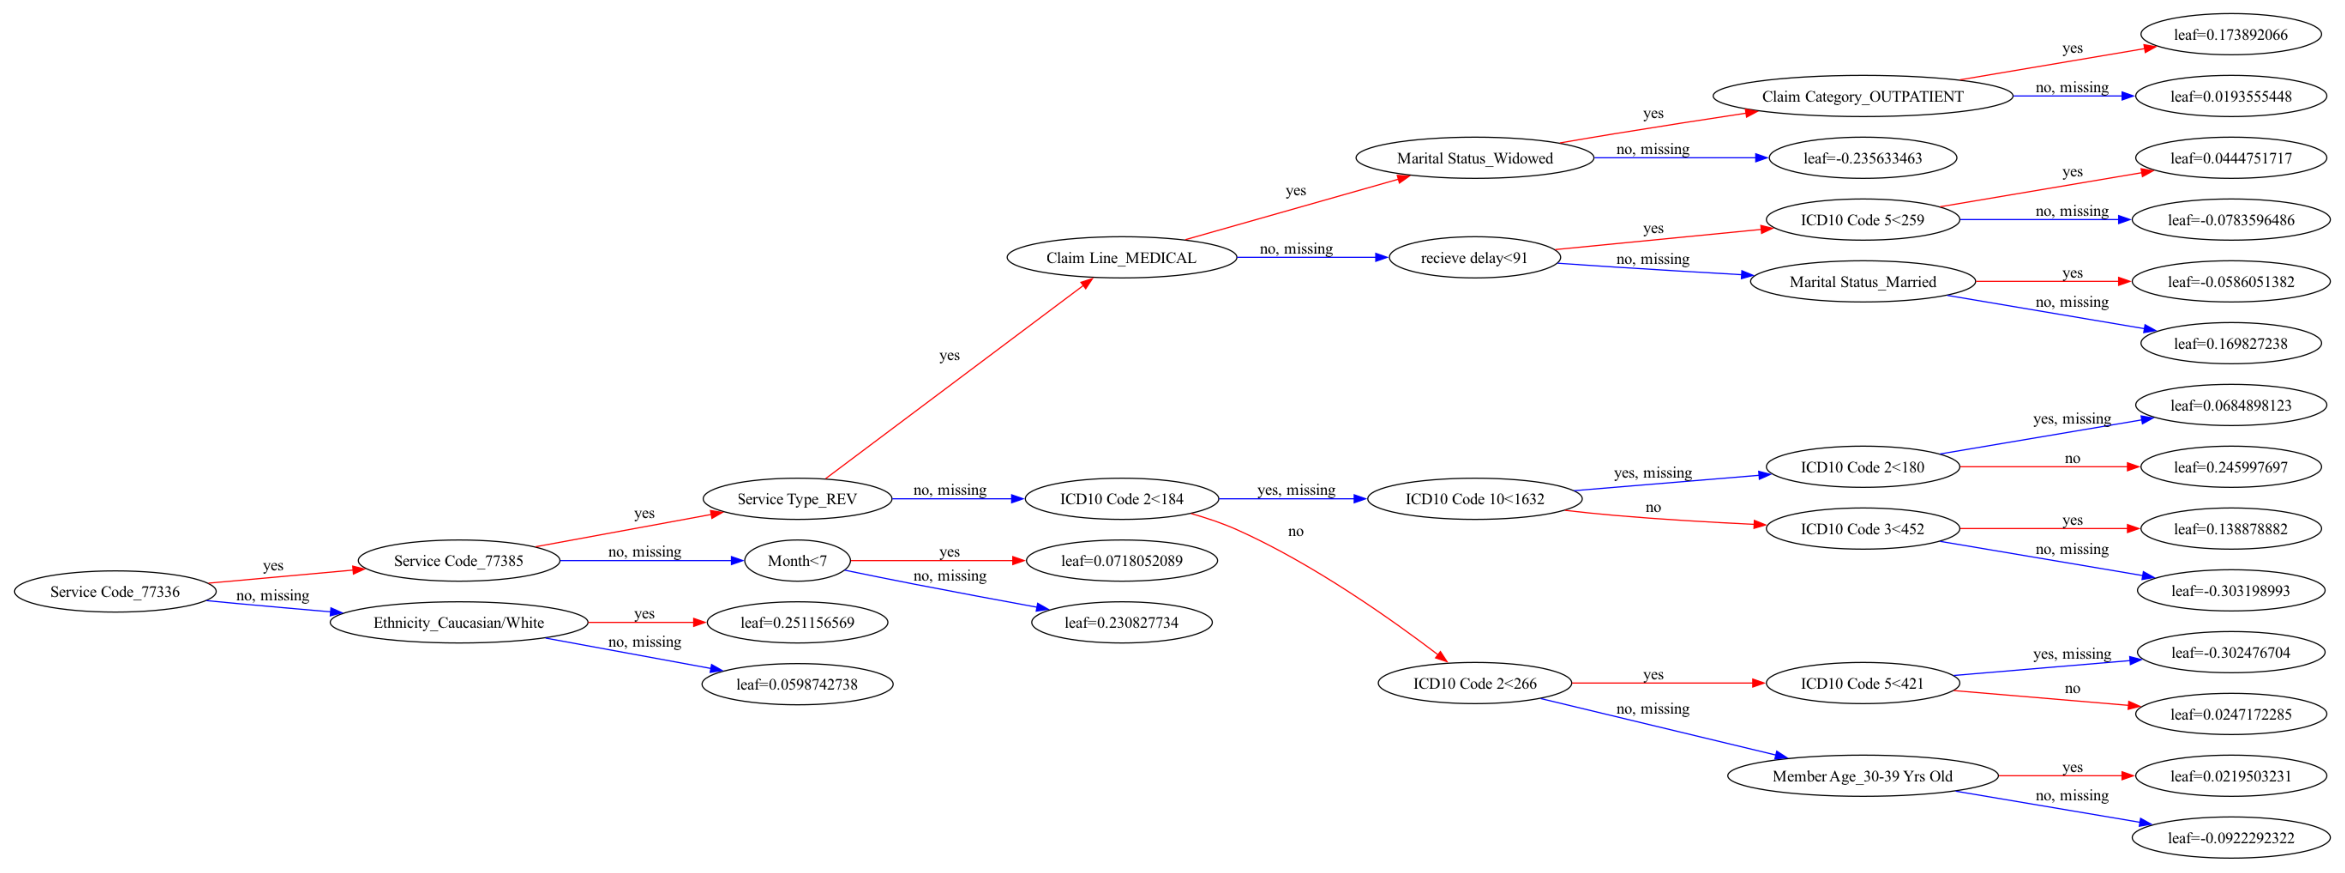

In [55]:
import matplotlib.pyplot as plt 
fig, ax = plt.subplots(figsize=(30, 20))
num_trees = model.get_num_boosting_rounds()
# print(num_trees)
plot_tree(model, num_trees=68, rankdir='LR', ax=ax)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

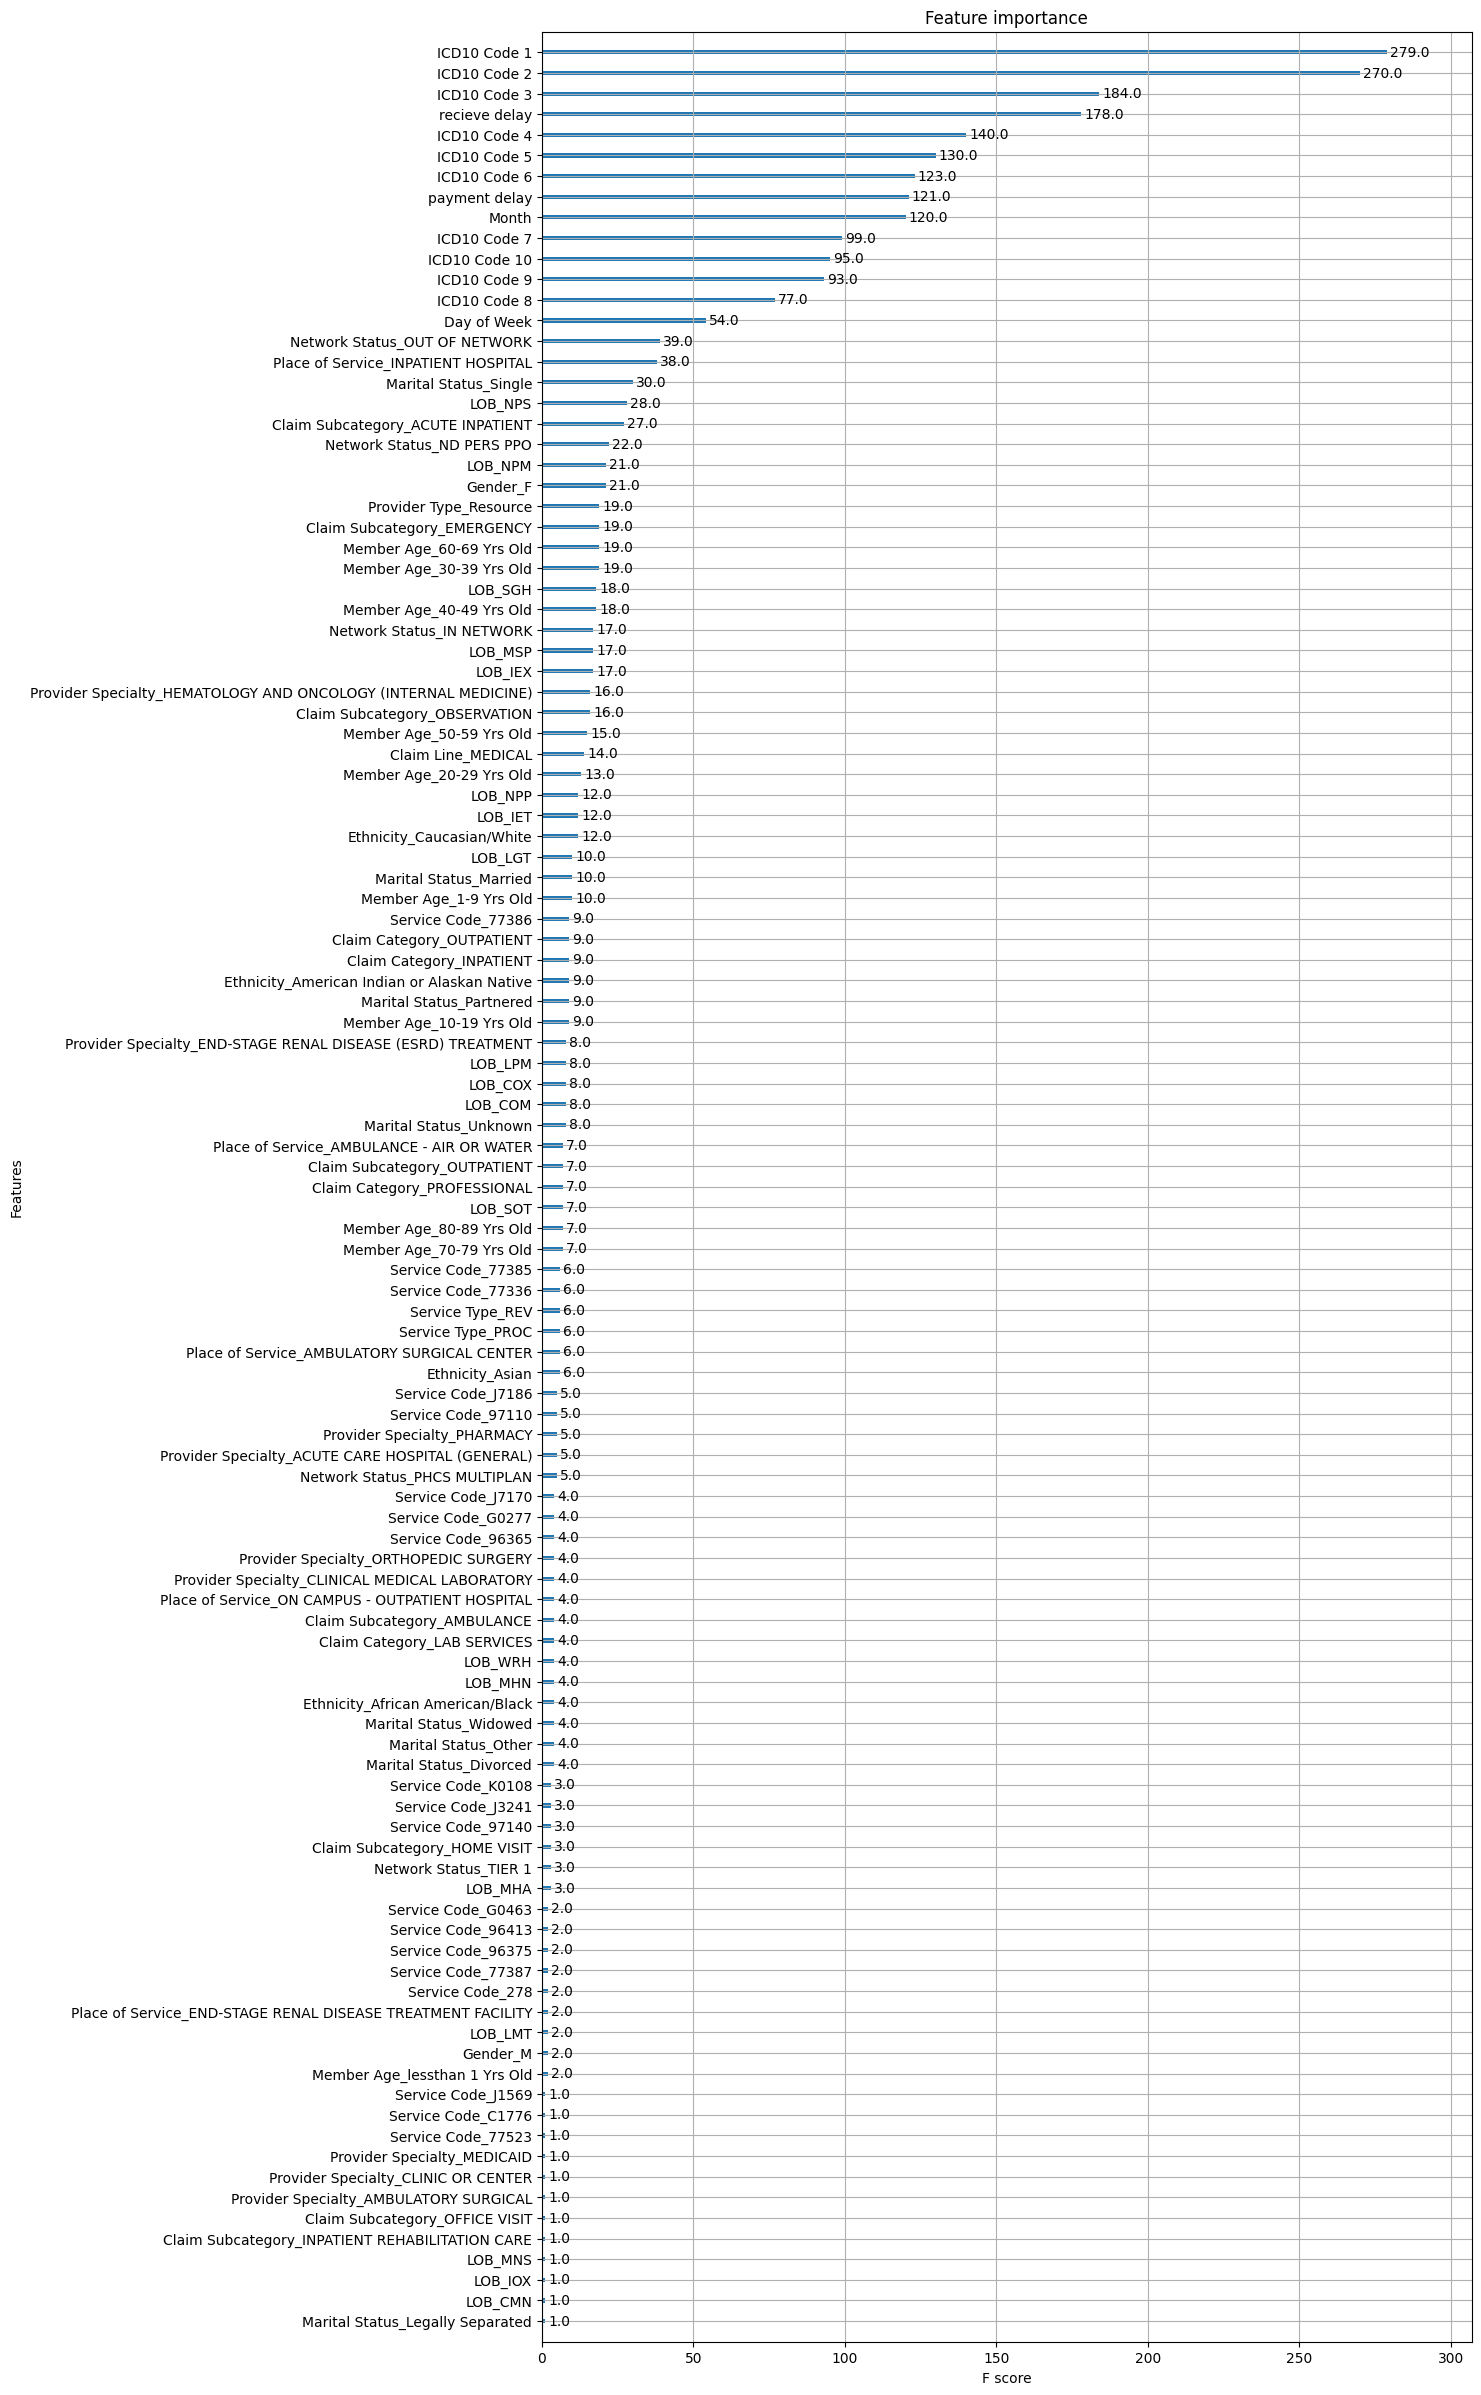

In [56]:
import matplotlib.pyplot as plt
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 30))
xgb.plot_importance(model, ax=ax)

In [58]:
import xgboost as xgb
import numpy as np
import optuna
from sklearn.metrics import average_precision_score


class CustomEarlyStopping(xgb.callback.TrainingCallback):
    """Stops training if the improvement is less than min_delta over early_stopping_rounds."""

    def __init__(self, early_stopping_rounds=50, min_delta=0.01):
        self.early_stopping_rounds = early_stopping_rounds
        self.min_delta = min_delta
        self.best_score = -np.inf
        self.best_iteration = 0
        self.counter = 0

    def after_iteration(self, model, epoch, evals_log):
        """Checks improvement after each round and stops if it's too small."""
        # Get latest validation score
        current_score = evals_log["valid"]["aucpr"][-1]

        # Check if improvement is greater than min_delta
        if current_score > self.best_score + self.min_delta:
            self.best_score = current_score
            self.best_iteration = epoch
            self.counter = 0  # Reset counter if improvement is significant
        else:
            self.counter += 1  # Increase counter if improvement is too small

        # Stop if no significant improvement in `early_stopping_rounds`
        if self.counter >= self.early_stopping_rounds:
            print(
                f"\nEarly stopping triggered at iteration {epoch} with best score {self.best_score:.5f}"
            )
            return True  # Returning True signals XGBoost to stop training

        return False  # Continue training

# Convert to DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_val, label=y_val)


# Define the objective function for Optuna
def objective(trial):
    params = {
        "objective": "binary:logistic",
        "eval_metric": "aucpr",
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True), # learning rate
        "max_depth": trial.suggest_int("max_depth", 1, 3),
        "max_leaves": trial.suggest_int("max_leaves", 1, 5),
        "lambda": trial.suggest_float("lambda", 1e-3, 10, log=True), # L2 regularization
        "alpha": trial.suggest_float("alpha", 1e-3, 10, log=True), # L1 regularization
        "gamma": trial.suggest_float("gamma", 1e-3, 5, log=True), # Minimum loss reduction required to make a further partition
        "subsample": trial.suggest_float("subsample", 0.5, 1.0), # Fraction of samples used to fit trees
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0), # Fraction of features used to fit trees
    }

    # Define your callback with a minimum improvement threshold of 0.01
    custom_early_stopping = CustomEarlyStopping(early_stopping_rounds=50, min_delta=0.001)

    # Train model with early stopping
    evals = [(dtrain, "train"), (dvalid, "valid")]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=1000,
        evals=evals,
        verbose_eval=False,
        callbacks=[custom_early_stopping],
    )
    
    best_iter = model.best_iteration if hasattr(model, "best_iteration") else model.num_boosted_rounds()

    # Predict and evaluate using AUC-PR
    y_pred = model.predict(dvalid, iteration_range=(0, best_iter))
    aucpr = average_precision_score(y_val, y_pred)
    return aucpr


# Run optimization
study = optuna.create_study(direction="maximize", storage="sqlite:///xgboost_study.db", study_name="xgboost_study", load_if_exists=True)
study.optimize(objective, n_trials=30)

# Get the best parameters
best_params = study.best_params
print("Best Hyperparameters:", best_params)

[I 2025-02-20 23:46:24,476] Using an existing study with name 'xgboost_study' instead of creating a new one.
[I 2025-02-20 23:48:39,609] Trial 30 finished with value: 0.9921839579511383 and parameters: {'eta': 0.1449354212711968, 'max_depth': 2, 'max_leaves': 4, 'lambda': 0.5572981264047717, 'alpha': 0.048838936810870516, 'gamma': 0.11441200763503674, 'subsample': 0.5959957665302608, 'colsample_bytree': 0.8651052135316105}. Best is trial 12 with value: 0.9937773052020429.



Early stopping triggered at iteration 935 with best score 0.99125


[I 2025-02-20 23:50:05,352] Trial 31 finished with value: 0.9944828089261238 and parameters: {'eta': 0.2904264177151415, 'max_depth': 3, 'max_leaves': 4, 'lambda': 1.6700562007324808, 'alpha': 0.008056269907336027, 'gamma': 0.0107553851766994, 'subsample': 0.5019692457336544, 'colsample_bytree': 0.6616533881335278}. Best is trial 31 with value: 0.9944828089261238.



Early stopping triggered at iteration 552 with best score 0.99350


[I 2025-02-20 23:52:04,975] Trial 32 finished with value: 0.994883491333882 and parameters: {'eta': 0.2950612397324627, 'max_depth': 3, 'max_leaves': 4, 'lambda': 4.8158882258616185, 'alpha': 0.018025277651779307, 'gamma': 0.01163115267333415, 'subsample': 0.5249515603004098, 'colsample_bytree': 0.663185791410729}. Best is trial 32 with value: 0.994883491333882.



Early stopping triggered at iteration 689 with best score 0.99389


[I 2025-02-20 23:55:01,189] Trial 33 finished with value: 0.981218078499021 and parameters: {'eta': 0.1901830189146673, 'max_depth': 3, 'max_leaves': 3, 'lambda': 5.267191435422543, 'alpha': 0.019273613957928076, 'gamma': 0.0030772951851624044, 'subsample': 0.5425251281553626, 'colsample_bytree': 0.6662960821394166}. Best is trial 32 with value: 0.994883491333882.
[I 2025-02-20 23:57:20,718] Trial 34 finished with value: 0.9927716430807353 and parameters: {'eta': 0.23067178233598123, 'max_depth': 3, 'max_leaves': 4, 'lambda': 5.726234637487811, 'alpha': 0.03127369593783147, 'gamma': 0.05021988285669321, 'subsample': 0.5939539779919616, 'colsample_bytree': 0.5737197585509474}. Best is trial 32 with value: 0.994883491333882.



Early stopping triggered at iteration 777 with best score 0.99187


[I 2025-02-21 00:01:18,145] Trial 35 finished with value: 0.9092918860681739 and parameters: {'eta': 0.011036517444463982, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.1588317366357312, 'alpha': 0.01423216335918242, 'gamma': 0.009760127700722038, 'subsample': 0.8294153417343954, 'colsample_bytree': 0.6551357345899659}. Best is trial 32 with value: 0.994883491333882.
[I 2025-02-21 00:04:57,009] Trial 36 finished with value: 0.9837733553727416 and parameters: {'eta': 0.1028211070062461, 'max_depth': 3, 'max_leaves': 4, 'lambda': 4.489902139064085, 'alpha': 0.0026525318288083354, 'gamma': 0.1721209314599438, 'subsample': 0.6405539214996551, 'colsample_bytree': 0.7613752219866591}. Best is trial 32 with value: 0.994883491333882.
[I 2025-02-21 00:07:49,241] Trial 37 finished with value: 0.9947268456116801 and parameters: {'eta': 0.17317199102409583, 'max_depth': 3, 'max_leaves': 5, 'lambda': 1.074537050942404, 'alpha': 0.052267157284734043, 'gamma': 0.022029165375119335, 'subsample': 0.9399


Early stopping triggered at iteration 740 with best score 0.99387


[I 2025-02-21 00:25:11,640] Trial 38 finished with value: 0.9925389524196161 and parameters: {'eta': 0.17739138310271324, 'max_depth': 3, 'max_leaves': 5, 'lambda': 8.891771336841835, 'alpha': 0.043399245351509894, 'gamma': 1.4526600994663919, 'subsample': 0.9207335487930887, 'colsample_bytree': 0.54412964146633}. Best is trial 32 with value: 0.994883491333882.



Early stopping triggered at iteration 755 with best score 0.99154


[I 2025-02-21 00:27:35,095] Trial 39 finished with value: 0.9934478445560546 and parameters: {'eta': 0.13382824498125673, 'max_depth': 3, 'max_leaves': 5, 'lambda': 0.6023675187620876, 'alpha': 0.09424764532894173, 'gamma': 0.021085248739746557, 'subsample': 0.9244411978853657, 'colsample_bytree': 0.5906864689857168}. Best is trial 32 with value: 0.994883491333882.



Early stopping triggered at iteration 822 with best score 0.99260


[I 2025-02-21 00:29:23,205] Trial 40 finished with value: 0.9955416294216202 and parameters: {'eta': 0.23749553457026001, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.1853229492135355, 'alpha': 0.06599054684988899, 'gamma': 0.03082548006427195, 'subsample': 0.9013540028269114, 'colsample_bytree': 0.5398370461228081}. Best is trial 40 with value: 0.9955416294216202.



Early stopping triggered at iteration 571 with best score 0.99471


[I 2025-02-21 00:31:21,124] Trial 41 finished with value: 0.9962639128325734 and parameters: {'eta': 0.23757788894130796, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.3508354697451455, 'alpha': 0.06824160737799018, 'gamma': 0.04521419002909322, 'subsample': 0.9260367566305661, 'colsample_bytree': 0.525037832212454}. Best is trial 41 with value: 0.9962639128325734.



Early stopping triggered at iteration 655 with best score 0.99572


[I 2025-02-21 00:33:24,559] Trial 42 finished with value: 0.996290095763676 and parameters: {'eta': 0.2228479508645001, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.2583132521704523, 'alpha': 0.4245121535981542, 'gamma': 0.03387406988802721, 'subsample': 0.9116742200482512, 'colsample_bytree': 0.5353317467591947}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 671 with best score 0.99545


[I 2025-02-21 00:35:27,347] Trial 43 finished with value: 0.9951329443173007 and parameters: {'eta': 0.2331326224143287, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.811266294089001, 'alpha': 0.42415785749308277, 'gamma': 0.034337384131117886, 'subsample': 0.9407201500908321, 'colsample_bytree': 0.5333151171853184}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 622 with best score 0.99443


[I 2025-02-21 00:37:52,652] Trial 44 finished with value: 0.995097001850296 and parameters: {'eta': 0.22460653133452801, 'max_depth': 3, 'max_leaves': 5, 'lambda': 9.971717072573458, 'alpha': 0.5137680063271481, 'gamma': 0.037673694864884, 'subsample': 0.8921367448335606, 'colsample_bytree': 0.5235310260827315}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 720 with best score 0.99411


[I 2025-02-21 00:40:24,150] Trial 45 finished with value: 0.9953747677572107 and parameters: {'eta': 0.23242166431741101, 'max_depth': 3, 'max_leaves': 5, 'lambda': 9.953897241369267, 'alpha': 0.4314209133639924, 'gamma': 0.03520976379600649, 'subsample': 0.8884569127562454, 'colsample_bytree': 0.5338729954241869}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 730 with best score 0.99473


[I 2025-02-21 00:42:24,969] Trial 46 finished with value: 0.994971118790566 and parameters: {'eta': 0.22591184836072067, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.3015073650392894, 'alpha': 0.4545594937930339, 'gamma': 0.0433577674908797, 'subsample': 0.9615846660592829, 'colsample_bytree': 0.5288461231318572}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 581 with best score 0.99408


[I 2025-02-21 00:45:44,763] Trial 47 finished with value: 0.9874118178284245 and parameters: {'eta': 0.10166844476363214, 'max_depth': 3, 'max_leaves': 5, 'lambda': 6.550421248760683, 'alpha': 0.21674968131310351, 'gamma': 0.09243923308221767, 'subsample': 0.8250432969176812, 'colsample_bytree': 0.571082749786237}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 943 with best score 0.98650


[I 2025-02-21 00:48:58,014] Trial 48 finished with value: 0.9941082217342715 and parameters: {'eta': 0.11920296717270916, 'max_depth': 3, 'max_leaves': 5, 'lambda': 0.007662493483274665, 'alpha': 1.2801585263233457, 'gamma': 0.03170938715900895, 'subsample': 0.877222659755166, 'colsample_bytree': 0.574232878408445}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 900 with best score 0.99316


[I 2025-02-21 00:51:14,933] Trial 49 finished with value: 0.9299479897787372 and parameters: {'eta': 0.2404747980832154, 'max_depth': 1, 'max_leaves': 5, 'lambda': 3.785879310871487, 'alpha': 0.3441003355221418, 'gamma': 0.05306501660665536, 'subsample': 0.9711727131037486, 'colsample_bytree': 0.5005957540815799}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 872 with best score 0.92892


[I 2025-02-21 00:53:36,600] Trial 50 finished with value: 0.9933933361246362 and parameters: {'eta': 0.1510664258416777, 'max_depth': 3, 'max_leaves': 5, 'lambda': 2.5135308655693027, 'alpha': 0.7007595107225114, 'gamma': 0.3089280275313287, 'subsample': 0.9086960272565842, 'colsample_bytree': 0.6063212265395028}. Best is trial 42 with value: 0.996290095763676.



Early stopping triggered at iteration 787 with best score 0.99256


[W 2025-02-21 00:54:36,274] Trial 51 failed with parameters: {'eta': 0.2434100332086498, 'max_depth': 3, 'max_leaves': 5, 'lambda': 8.067596978604929, 'alpha': 1.343330768252288, 'gamma': 0.03285769931525364, 'subsample': 0.882704121520336, 'colsample_bytree': 0.5265509442735378} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/Users/samyamaryal/Desktop/Data Competition/DSU-Data-Competition-Spring2025/.venv/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/f1/j41ycv7j5p38hx17_9csz05h0000gn/T/ipykernel_23532/4216502470.py", line 64, in objective
    model = xgb.train(
            ^^^^^^^^^^
  File "/Users/samyamaryal/Desktop/Data Competition/DSU-Data-Competition-Spring2025/.venv/lib/python3.11/site-packages/xgboost/core.py", line 726, in inner_f
    return func(**kwargs)
           ^^^^^^^^^^^^^^
  File "/Users/samyamarya

KeyboardInterrupt: 

In [59]:
study.trials_dataframe().sort_values("value", ascending=False)

,number,value,datetime_start,datetime_complete,duration,params_alpha,params_colsample_bytree,params_eta,params_gamma,params_lambda,params_max_depth,params_max_leaves,params_subsample,state
42,42,0.996290,2025-02-21 00:31:21.128089,2025-02-21 00:33:24.554796,0 days 00:02:03.426707,0.424512,0.535332,0.222848,0.033874,2.258313,3,5,0.911674,COMPLETE
41,41,0.996264,2025-02-21 00:29:23.208333,2025-02-21 00:31:21.120218,0 days 00:01:57.911885,0.068242,0.525038,0.237578,0.045214,2.350835,3,5,0.926037,COMPLETE
40,40,0.995542,2025-02-21 00:27:35.098961,2025-02-21 00:29:23.200462,0 days 00:01:48.101501,0.065991,0.539837,0.237496,0.030825,2.185323,3,5,0.901354,COMPLETE
45,45,0.995375,2025-02-21 00:37:52.655996,2025-02-21 00:40:24.144834,0 days 00:02:31.488838,0.431421,0.533873,0.232422,0.035210,9.953897,3,5,0.888457,COMPLETE
43,43,0.995133,2025-02-21 00:33:24.562259,2025-02-21 00:35:27.342969,0 days 00:02:02.780710,0.424158,0.533315,0.233133,0.034337,2.811266,3,5,0.940720,COMPLETE
44,44,0.995097,2025-02-21 00:35:27.350808,2025-02-21 00:37:52.646840,0 days 00:02:25.296032,0.513768,0.523531,0.224607,0.037674,9.971717,3,5,0.892137,COMPLETE
46,46,0.994971,2025-02-21 00:40:24.154322,2025-02-21 00:42:24.963020,0 days 00:02:00.808698,0.454559,0.528846,0.225912,0.043358,2.301507,3,5,0.961585,COMPLETE
32,32,0.994883,2025-02-20 23:50:05.355910,2025-02-20 23:52:04.970848,0 days 00:01:59.614938,0.018025,0.663186,0.295061,0.011631,4.815888,3,4,0.524952,COMPLETE
37,37,0.994727,2025-02-21 00:04:57.015431,2025-02-21 00:07:49.234774,0 days 00:02:52.219343,0.052267,0.550070,0.173172,0.022029,1.074537,3,5,0.939923,COMPLETE
31,31,0.994483,2025-02-20 23:48:39.612870,2025-02-20 23:50:05.347562,0 days 00:01:25.734692,0.008056,0.661653,0.290426,0.010755,1.670056,3,4,0.501969,COMPLETE


In [60]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Ensure CustomEarlyStopping is already defined
custom_early_stopping = CustomEarlyStopping(early_stopping_rounds=50, min_delta=0.001)

# Correct the order of train_test_split return values
X_train, X_val, y_train, y_val = train_test_split(df_short, labels)

params = {
    "eval_metric": "aucpr",
    "eta": 0.295,  # learning rate
    "max_depth": 3,
    "max_leaves": 4,
    "lambda": 0.591,  # L2 regularization
    "alpha": 0.146,  # L1 regularization
    "gamma": 0.152,  # Minimum loss reduction required to make a further partition
    "subsample": 0.515,  # Fraction of samples used to fit trees
    "colsample_bytree": 0.656,  # Fraction of features used to fit trees
}

dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

model = xgb.train(params, dtrain, num_boost_round=1000, evals=[(dtrain, "train"), (dval, "valid")], verbose_eval=10, callbacks=[custom_early_stopping])

[0]	train-aucpr:0.65362	valid-aucpr:0.65808
[10]	train-aucpr:0.81464	valid-aucpr:0.81319
[20]	train-aucpr:0.84820	valid-aucpr:0.84677
[30]	train-aucpr:0.86575	valid-aucpr:0.86266
[40]	train-aucpr:0.87452	valid-aucpr:0.87115
[50]	train-aucpr:0.88039	valid-aucpr:0.87624
[60]	train-aucpr:0.88766	valid-aucpr:0.88329
[70]	train-aucpr:0.89206	valid-aucpr:0.88753
[80]	train-aucpr:0.89577	valid-aucpr:0.89082
[90]	train-aucpr:0.89882	valid-aucpr:0.89270
[100]	train-aucpr:0.90170	valid-aucpr:0.89536
[110]	train-aucpr:0.90510	valid-aucpr:0.89779
[120]	train-aucpr:0.90814	valid-aucpr:0.90047
[130]	train-aucpr:0.91179	valid-aucpr:0.90386
[140]	train-aucpr:0.91466	valid-aucpr:0.90632
[150]	train-aucpr:0.91595	valid-aucpr:0.90730
[160]	train-aucpr:0.91707	valid-aucpr:0.90842
[170]	train-aucpr:0.92042	valid-aucpr:0.91115
[180]	train-aucpr:0.92272	valid-aucpr:0.91245
[190]	train-aucpr:0.92424	valid-aucpr:0.91389
[200]	train-aucpr:0.92587	valid-aucpr:0.91526
[210]	train-aucpr:0.92841	valid-aucpr:0.91774

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

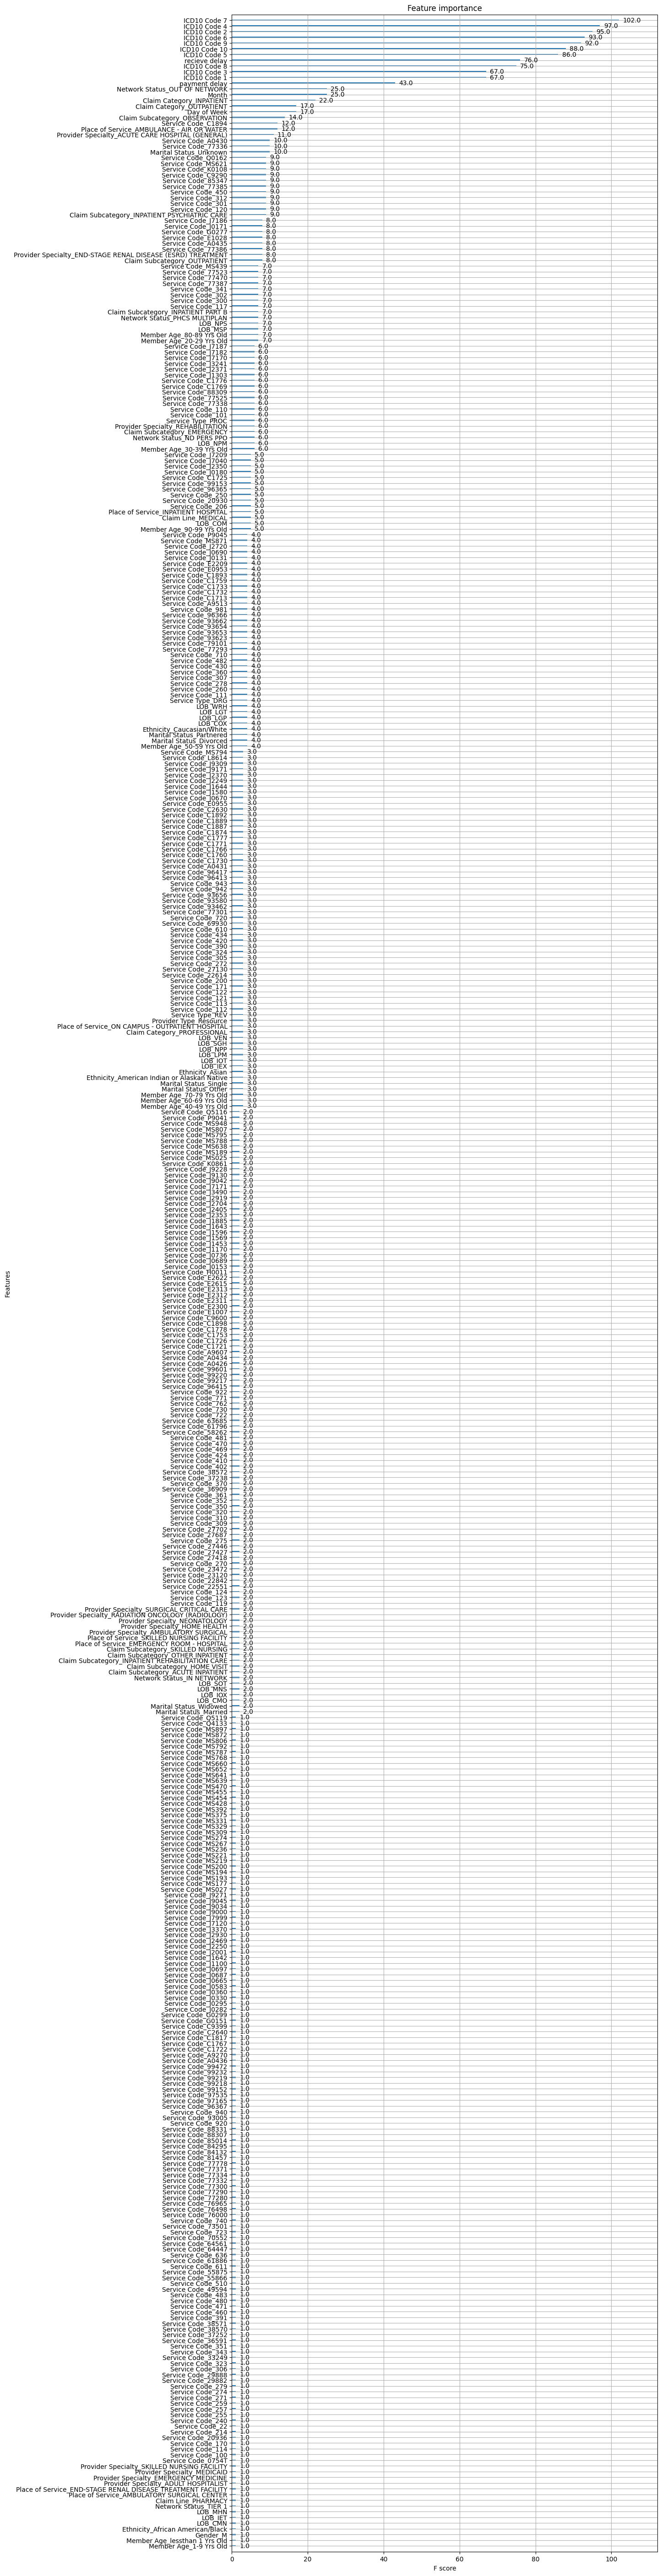

In [61]:
plt.style.use("default")
fig, ax = plt.subplots(figsize=(12, 72))
xgb.plot_importance(model, ax=ax)